# Creating a rotation matrix for a stellar stream

Written by Andrew Li | May 2024

In the AAU tutorial, I mentioned that the rotation amtrix may not be provided for all streams, such as 300S or Jet. In this tutorial, we will create a rotation matrix for 300S.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import table
import matplotlib

In [6]:
font = {'size'   : 16}
matplotlib.rc('font', **font)

In [7]:
# 300s footprint

table_S5_full = table.Table.read('/raid/S5/idr3/cat_s5_dr3.7.fits')
stream_data = table_S5_full[table_S5_full['object_name'] == '300S']

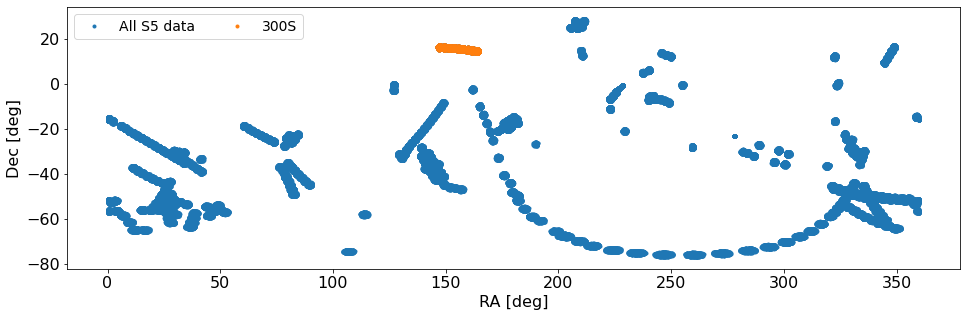

In [8]:
fig, ax = plt.subplots(1,1,figsize=(16,8))


ax.plot(table_S5_full['ra'],table_S5_full['dec'],'.',label='All S5 data')
ax.plot(stream_data['ra'],stream_data['dec'],'.',label='300S')
ax.set(xlabel="RA [deg]", ylabel="Dec [deg]",aspect='equal')
ax.legend(ncol=2,loc=2,prop={'size':14})

plt.subplots_adjust()

Here we can see the 300S stream in orange. To find a suitable rotation matrix, we want $(\phi_1,\phi_2)=(0,0)$ to be near the center of the stream, and we want $\phi1$ to be parallel to the streams orbit. For stellar streams, this is almost always in the same direction as the leading arm of the stream. The stream's orbit can be determined if you know its 6-d position and kinematics and using the $\texttt{galpy}$ package, but this is really only necessary if you are trying to find a tidal tail in a GC or DG.

To generate a streams rotation matrix, you only need to determine the equatorial cooridnates of the center of the stream ($\alpha_0$ and $\delta_0$), and the pivot angle. For 300S, we can estimate these parameters in the following cell.

In [9]:
ra0 = 155
dec0 = 15
pa = np.radians(0)

This really is all you need to do, just mess around with these three numbers until you feel satisfied. But if you want to know more, keep reading :).

First, we define the following fucntions to ease conversions between equatorial and cartesian coordinates. We will also define the unit vectors here.

In [10]:
def radec_to_cartesian(alpha,delta):
    x = np.cos(alpha)*np.cos(delta)
    y = np.sin(alpha)*np.cos(delta)
    z = np.sin(delta)
    return np.array([x,y,z])

def cartesian_to_radec(x,y,z):
    delta = np.arcsin(z)
    alpha = np.arctan(y/x)
    return np.array([alpha,delta])

xhat = np.array([1,0,0])
yhat = np.array([0,1,0])
zhat = np.array([0,0,1])

We will also define the same function from the AAU tutorial which converts (RA, Dec) to (phi1, phi2).

In [11]:
def phi12_rotmat(alpha,delta,R_phi12_radec):
    '''
    Converts coordinates (alpha,delta) to ones defined by a rotation matrix R_phi12_radec, applied on the original coordinates

    Critical: All angles must be in degrees
    
    Parameters:
    alpha - float. Right ascension
    delta - float. Declination
    R_phi12_radec - 3x3 array. Rotation matrix
    
    Returns:
    [phi1,phi2] - the transformed stream coordinates as a size 2 array.
    '''
    
    vec_radec = np.array([np.cos(alpha*np.pi/180.)*np.cos(delta*np.pi/180.),
                          np.sin(alpha*np.pi/180.)*np.cos(delta*np.pi/180.),
                          np.sin(delta*np.pi/180.)])

    vec_phi12 = np.zeros(np.shape(vec_radec))
    
    vec_phi12[0] = np.sum(R_phi12_radec[0][i]*vec_radec[i] for i in range(3))
    vec_phi12[1] = np.sum(R_phi12_radec[1][i]*vec_radec[i] for i in range(3))
    vec_phi12[2] = np.sum(R_phi12_radec[2][i]*vec_radec[i] for i in range(3))
    
    vec_phi12 = vec_phi12.T

    vec_phi12 = np.dot(R_phi12_radec,vec_radec).T

    phi1 = np.arctan2(vec_phi12[:,1],vec_phi12[:,0])*180./np.pi
    phi2 = np.arcsin(vec_phi12[:,2])*180./np.pi

    return [phi1,phi2]

The following cell will generate the rotation matrix $\texttt{smatrix}$.

In [12]:
def RotationMatrix(nhat,theta):
    c = np.cos(theta)
    s = np.sin(theta)
    none = nhat[0].astype(float)
    ntwo = nhat[1].astype(float)
    nthree = nhat[2].astype(float)
    R = np.array([[c+(none**2)*(1-c), none*ntwo*(1-c)-nthree*s, none*nthree*(1-c)+ntwo*s],[none*ntwo*(1-c)+nthree*s, c+(ntwo**2)*(1-c), ntwo*nthree*(1-c)-none*s],[none*nthree*(1-c)-ntwo*s, ntwo*nthree*(1-c)+none*s, c+(nthree**2)*(1-c)]])
    return R

center_ra = np.radians(ra0)
center_dec = np.radians(dec0)
center = radec_to_cartesian(center_ra,center_dec)


Ralpha = RotationMatrix(zhat,center_ra)
Rdelta = RotationMatrix(RotationMatrix(zhat,center_ra-np.pi/2)@xhat,center_dec)
Rpa = RotationMatrix(center,np.pi/2-pa)
Rtot = Rpa@(Rdelta@Ralpha)
smatrix = np.linalg.inv(Rtot)

In [13]:
smatrix

array([[-8.75426098e-01,  4.08217894e-01,  2.58819045e-01],
       [ 2.34569716e-01, -1.09381655e-01,  9.65925826e-01],
       [ 4.22618262e-01,  9.06307787e-01,  4.85959105e-17]])

In [14]:
#Convert

table_S5_full['phi1'], table_S5_full['phi2'] = phi12_rotmat(table_S5_full['ra'],table_S5_full['dec'],smatrix)
stream_data['phi1'], stream_data['phi2'] = phi12_rotmat(stream_data['ra'],stream_data['dec'],smatrix)

/tmp/ipykernel_1839924/3158834505.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  vec_phi12[0] = np.sum(R_phi12_radec[0][i]*vec_radec[i] for i in range(3))
/tmp/ipykernel_1839924/3158834505.py:23: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  vec_phi12[1] = np.sum(R_phi12_radec[1][i]*vec_radec[i] for i in range(3))
/tmp/ipykernel_1839924/3158834505.py:24: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  vec_phi12[2] = np.sum(R_phi12_radec[2][i]*vec_radec[i] for i in range(3))


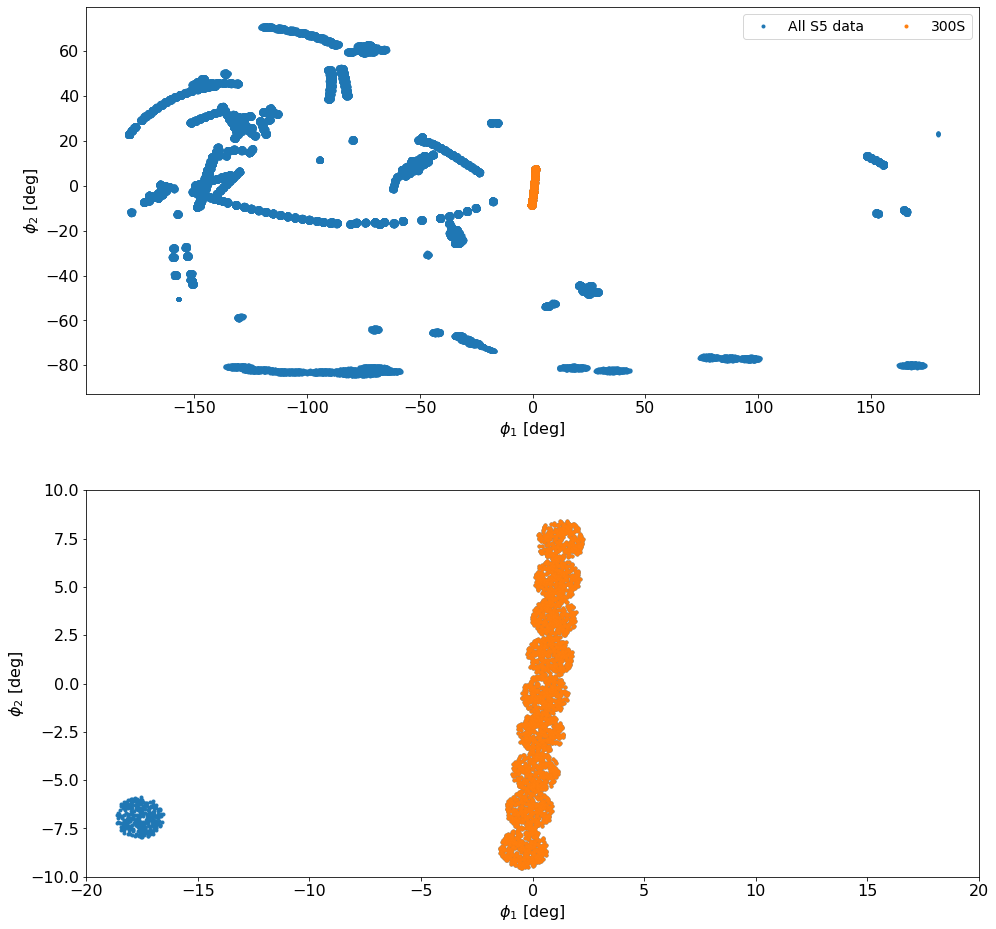

In [15]:
fig, ax = plt.subplots(2,1,figsize=(16,16))

ax[0].plot(table_S5_full['phi1'],table_S5_full['phi2'],'.',label='All S5 data')
ax[0].plot(stream_data['phi1'],stream_data['phi2'],'.',label='300S')
ax[0].set(xlabel="$\phi_1$ [deg]", ylabel="$\phi_2$ [deg]")
ax[0].legend(ncol=2,prop={'size':14})

ax[1].plot(table_S5_full['phi1'],table_S5_full['phi2'],'.')
ax[1].plot(stream_data['phi1'],stream_data['phi2'],'.')
ax[1].set(xlabel="$\phi_1$ [deg]", ylabel="$\phi_2$ [deg]",xlim=(-20,20),ylim=(-10,10))

plt.subplots_adjust(hspace=0.25)

It seems our ra0 and dec0 guesses were close, but the angle is quite far off. You can just make your own adjustments and guesses at this point and mess around until this looks good. Here is what I settled on.

/tmp/ipykernel_1839924/3158834505.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  vec_phi12[0] = np.sum(R_phi12_radec[0][i]*vec_radec[i] for i in range(3))
/tmp/ipykernel_1839924/3158834505.py:23: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  vec_phi12[1] = np.sum(R_phi12_radec[1][i]*vec_radec[i] for i in range(3))
/tmp/ipykernel_1839924/3158834505.py:24: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  vec_phi12[2] = np.sum(R_phi12_radec[2][i]*vec_radec[i] for i in range(3))


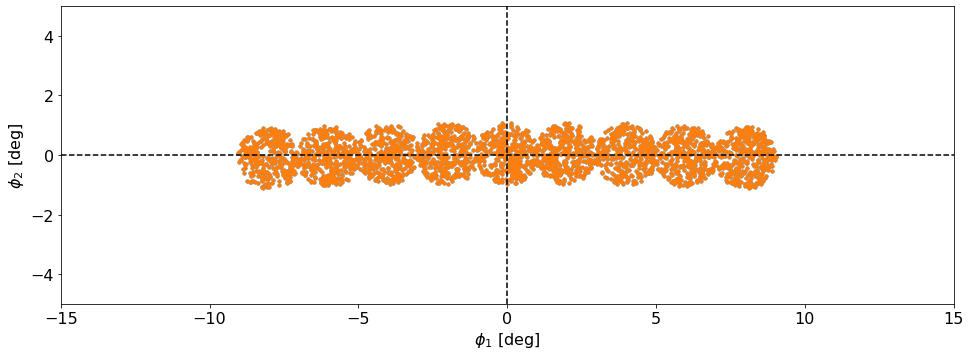

In [19]:
ra0 = 155.6
dec0 = 15.5
pa = np.radians(96.2)

center_ra = np.radians(ra0)
center_dec = np.radians(dec0)
center = radec_to_cartesian(center_ra,center_dec)
Ralpha = RotationMatrix(zhat,center_ra)
Rdelta = RotationMatrix(RotationMatrix(zhat,center_ra-np.pi/2)@xhat,center_dec)
Rpa = RotationMatrix(center,np.pi/2-pa)
Rtot = Rpa@(Rdelta@Ralpha)
smatrix = np.linalg.inv(Rtot)

table_S5_full['phi1'], table_S5_full['phi2'] = phi12_rotmat(table_S5_full['ra'],table_S5_full['dec'],smatrix)
stream_data['phi1'], stream_data['phi2'] = phi12_rotmat(stream_data['ra'],stream_data['dec'],smatrix)



fig, ax = plt.subplots(1,1,figsize=(16,16))

ax.plot(table_S5_full['phi1'],table_S5_full['phi2'],'.')
ax.plot(stream_data['phi1'],stream_data['phi2'],'.')
ax.set(xlabel="$\phi_1$ [deg]", ylabel="$\phi_2$ [deg]",xlim=(-15,15),ylim=(-5,5),aspect='equal')
ax.axvline(0,c='k',ls='--')
ax.axhline(0,c='k',ls='--')

In [17]:
smatrix

array([[-0.87756251,  0.39808001,  0.26723838],
       [-0.43697193, -0.8934342 , -0.10407147],
       [ 0.19733113, -0.20810489,  0.95799414]])